# [AIG100 – Project 2: Regression and Classification Methods](https://github.com/jcp-tech/Seneca_Class_Notes/tree/master/Semester%201/AIG100%20-%20Machine%20Learing/Project%202)

## Initialising Libraries and Functions

In [75]:
!pip install numpy pandas matplotlib seaborn scikit-learn kagglehub ucimlrepo

In [76]:
# Import required libraries
import matplotlib.pyplot as plt
# import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
# import math

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load the dataset & Ignore warnings
from ucimlrepo import fetch_ucirepo # , list_available_datasets
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [77]:
# def binary_classification_metrics(y_test, y_pred):
#     threshold = 0.5
#     y_pred_binary = (y_pred > threshold).astype(int)
#     y_test_binary = (y_test > threshold).astype(int)
#     return y_test_binary, y_pred_binary

def create_pipeline(
        df,
        target,
        model_type, #='regressor',
    ):
    # Create preprocessing pipelines for numerical and categorical data
    numeric_features = [f for f in df.select_dtypes(include=[np.number, 'number', 'float64', 'int64', 'float32', 'int32']).columns.to_list() if f != target]
    categorical_features = [f for f in df.select_dtypes(include=["object", "category"]).columns.to_list() if f != target ]
    # Numeric pipeline with standard scaling
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    # Categorical pipeline with one-hot encoding
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(
            # drop='first',
            # sparse_output=False, # Return dense array
            handle_unknown="ignore"
        ))
    ])
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    # Create X and y
    X, y = df.drop(target, axis=1), df[target] # df.filter([target])
    # Create full pipeline with preprocessor
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        (model_type, None)  # This will be set later for each model
    ])
    return model_pipeline, X, y

def train_and_evaluate_models(
        models_dict,
        model_type,
        model_pipeline,
        X, y,
        train_percent=80,#%
    ):
    X_train, X_test, y_train, y_test = train_test_split(
        X,y,
        test_size=1-train_percent/100,
        random_state=42
    )
    # Dictionary to store results
    modelStorage = {}
    prediction_data = {}
    results = {}
    # Train and evaluate each model
    for name, model in models_dict.items():
        if model_type == 'regressor':
            model_pipeline.set_params(regressor=model)
        elif model_type == 'classifier':
            model_pipeline.set_params(classifier=model)
        else:
            raise ValueError("model_type must be either 'regressor' or 'classifier'")
        model_pipeline.fit(X_train, y_train) # Fit the model
        modelStorage[name] = model_pipeline
    # for name, model_pipeline in modelStorage.items():
        y_pred = model_pipeline.predict(X_test) # Make predictions
        # Store prediction data for later
        prediction_data[name] = {
            'actual': y_test,
            'predicted': y_pred
        }
        # Calculate metrics
        if model_type == 'regressor': # 'regressor' in model_pipeline.named_steps:
            results[name] = {
                'MAE': mean_absolute_error(y_test, y_pred),
                'MSE': mean_squared_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'Rsqr': r2_score(y_test, y_pred)
                # 'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            }
        elif model_type == 'classifier': # 'classifier' in model_pipeline.named_steps:
            results[name] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average='weighted'),
                'Recall': recall_score(y_test, y_pred, average='weighted'),
                'F1-Score': f1_score(y_test, y_pred, average='weighted'),
                # 'Classification Report': classification_report(y_test, y_pred)
            }
    return modelStorage, prediction_data, results

def plot_metrics_from_df(results_df):
    metrics = results_df.columns.to_list()[:-1] # Exclude the TYPE column
    # Determine number of rows and columns for subplots
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = int(np.ceil(n_metrics / n_cols))
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
    axes = axes.flatten() if n_metrics > 1 else [axes]  # Handle a single plot case
    # Loop through each metric and create a barplot in each subplot
    for i, column in enumerate(metrics):
        sns.barplot(x=results_df.index, y=column, data=results_df, palette='viridis', ax=axes[i])
        # Add values on top of the bars
        for index, value in enumerate(results_df[column]):
            axes[i].text(index, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=12)
        # Set the title, labels, and other plot properties for each subplot
        axes[i].set_title(f'{column} - Model Performance')
        axes[i].set_xlabel('') # Model
        axes[i].set_ylabel(column)
        axes[i].tick_params(axis='x', rotation=45)
    # Remove any empty subplots if metrics < n_rows * n_cols
    for i in range(n_metrics, n_rows * n_cols):
        fig.delaxes(axes[i])
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.2)  # Increase horizontal and vertical spacing
    plt.show()

def get_best_model(results_df, model_type):
    if model_type == 'regressor':
        # Relevant metrics for regression (lower is better for error metrics, higher for R2)
        results_df['Score'] = results_df[['MAE', 'MSE', 'RMSE']].mean(axis=1) - results_df['Rsqr']
        best_model = results_df['Score'].idxmin()
    elif model_type == 'classifier':
        # Relevant metrics for classification (higher is better)
        results_df['Score'] = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean(axis=1)
        best_model = results_df['Score'].idxmax()
    else:
        raise ValueError("Invalid model type. Use 'regressor' or 'classifier'")
    # print(results_df)
    return best_model

--------------------------------------------------

# Regression Task
**Dataset**: Flight Price Prediction dataset

**Source**: [Kaggle](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction)

**Objective**: To predict the price of airline tickets based on various features such as airline, flight details, source and destination cities, departure and arrival times, number of stops, class, duration, and days left before the flight. This regression model will help travelers anticipate flight costs and potentially make more economical travel decisions.

## Regression Dataset

In [78]:
try:
  df_regression = kagglehub.load_dataset(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    "shubhambathwal/flight-price-prediction",
    "Clean_Dataset.csv",
  )
except Exception as e:
  print(f"Error loading dataset: {e}")
  path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction") # Download latest version
  df_regression = pd.read_csv(path+"/Clean_Dataset.csv")
finally:
  X = df_regression.drop(columns=['price']) # Features
  y = df_regression['price'] # Target variable
  # df_regression = pd.concat([X, y], axis=1) # concatenate features and target variable
  df_regression.drop(columns=['Unnamed: 0'], inplace=True) # Drop the unnessary index column
df_regression

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


## Understanding the Data

In [79]:
# Tells about the data types and their distribution
df_regression.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


In [80]:
# Tells about the number of rows and columns in the dataset
df_regression.shape # (rows, columns)

(300153, 11)

In [81]:
# Tells about the data types of each column
df_regression.info() # df_regression.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [82]:
# Tells us if there are any missing values in the dataset
print("Missing values in the dataset:")
int(df_regression.isnull().sum().sum()) # There aren't any missing values in the dataset

Missing values in the dataset:


0

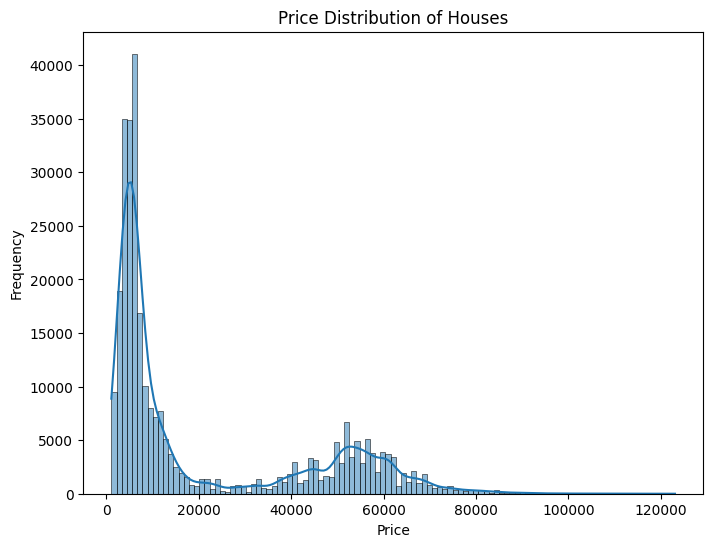

In [83]:
# Examine class distribution of the target variable price
plt.figure(figsize=(8, 6)) # (20, 15)
sns.histplot(df_regression['price'], kde=True)
plt.title('Price Distribution of Houses')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

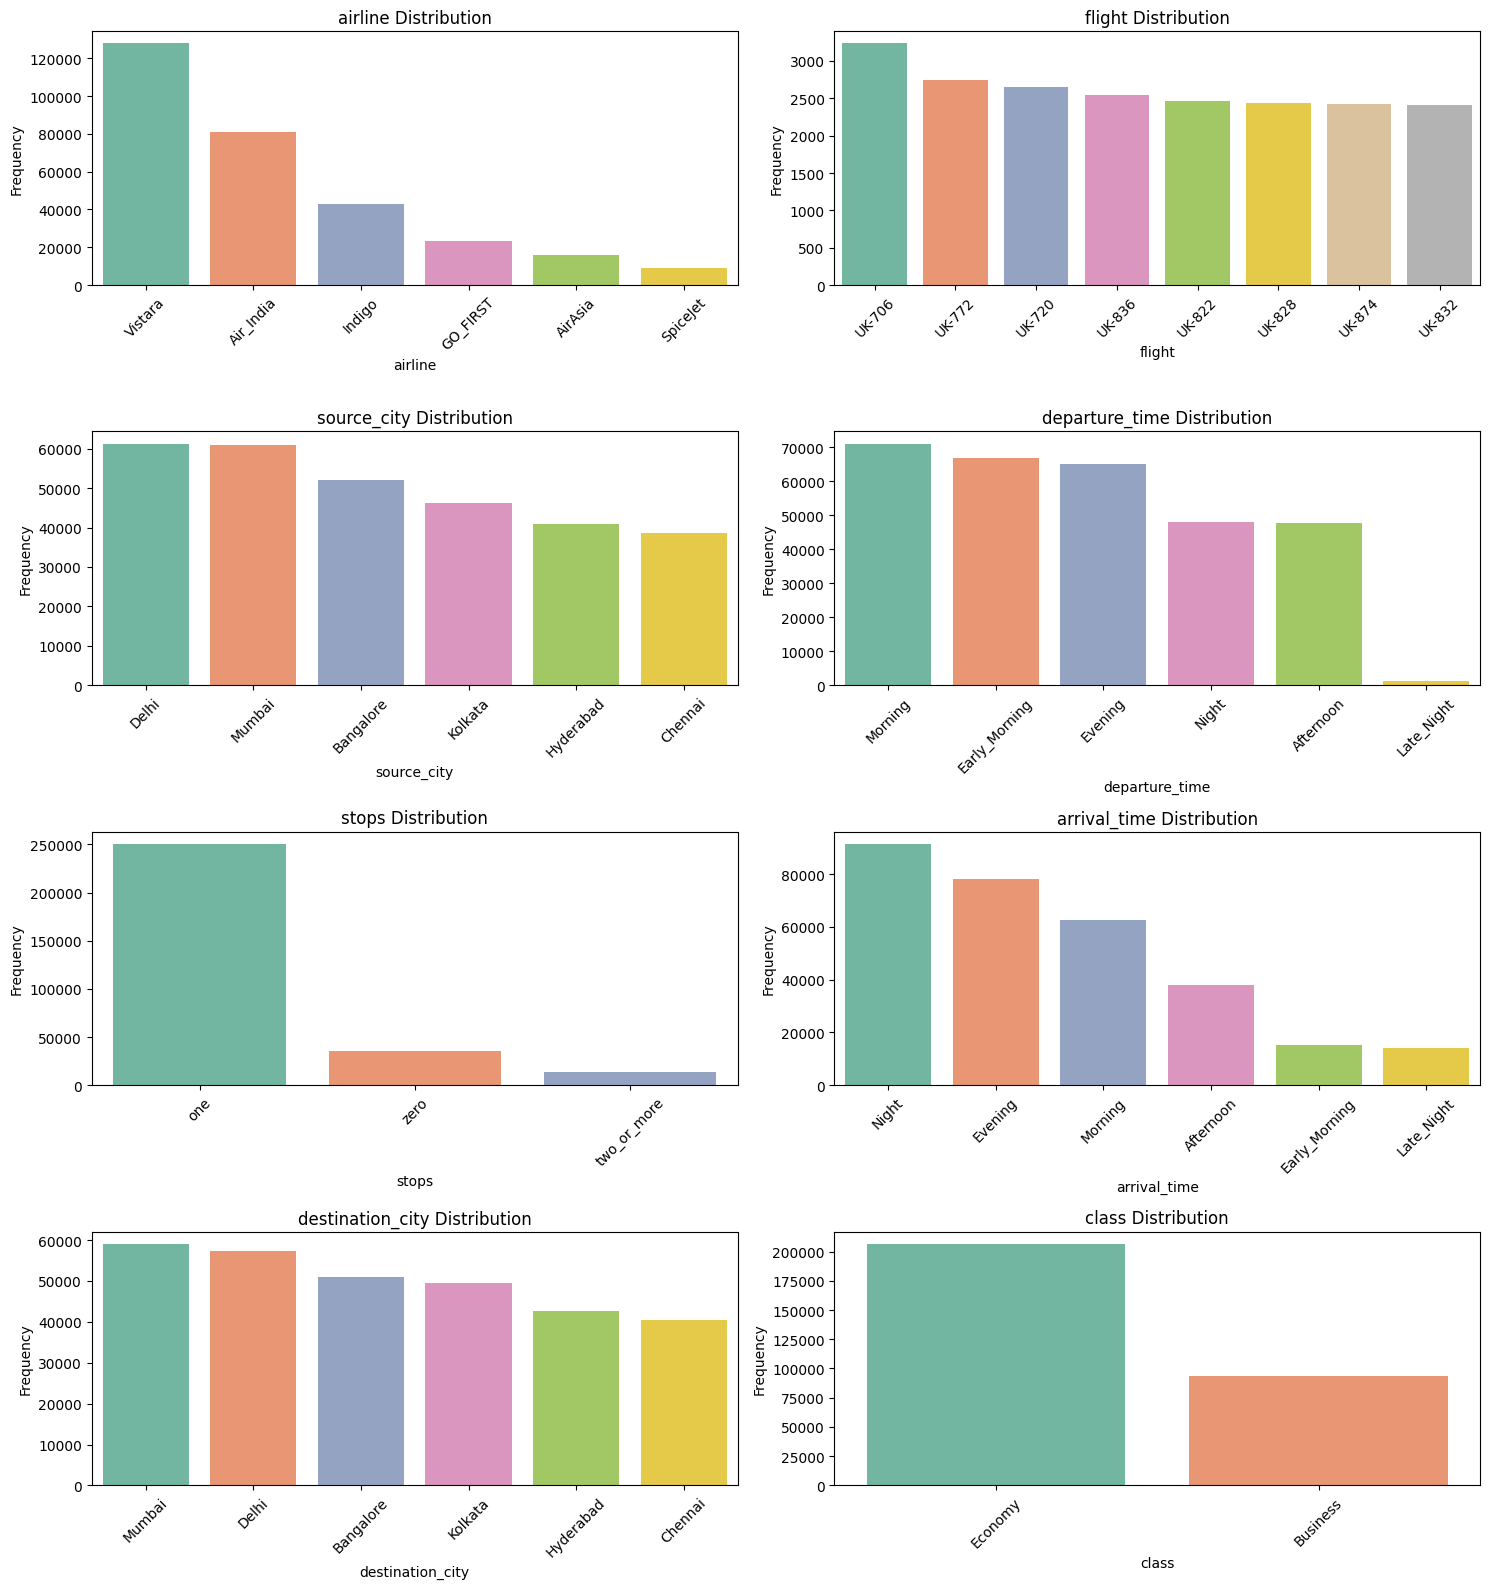

In [84]:
# Show Bar Distribution of Categorical Variables in one figure
categorical_cols = df_regression.select_dtypes(include='object').columns
n_cols = len(categorical_cols)
n_rows = (n_cols + 1) // 2  # Calculate number of rows needed (2 columns per row)
# Create a color palette using a different scheme
colors = sns.color_palette("Set2", 8)  # Using Set2 palette instead of husl
plt.figure(figsize=(15, 4*n_rows))
for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(n_rows, 2, idx)
    data = df_regression[col].value_counts()
    data = data.head(8) if len(data) > 8 else data  # Display only top 8 categories if there are more than 8 categories
    sns.barplot(x=data.index, y=data.values, palette=colors)
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()
# # Display value counts for categorical variables
# for col in df_regression.select_dtypes(include='object').columns:
#     print(f"Column: {col}")
#     print(df_regression[col].value_counts())
#     print("\n")

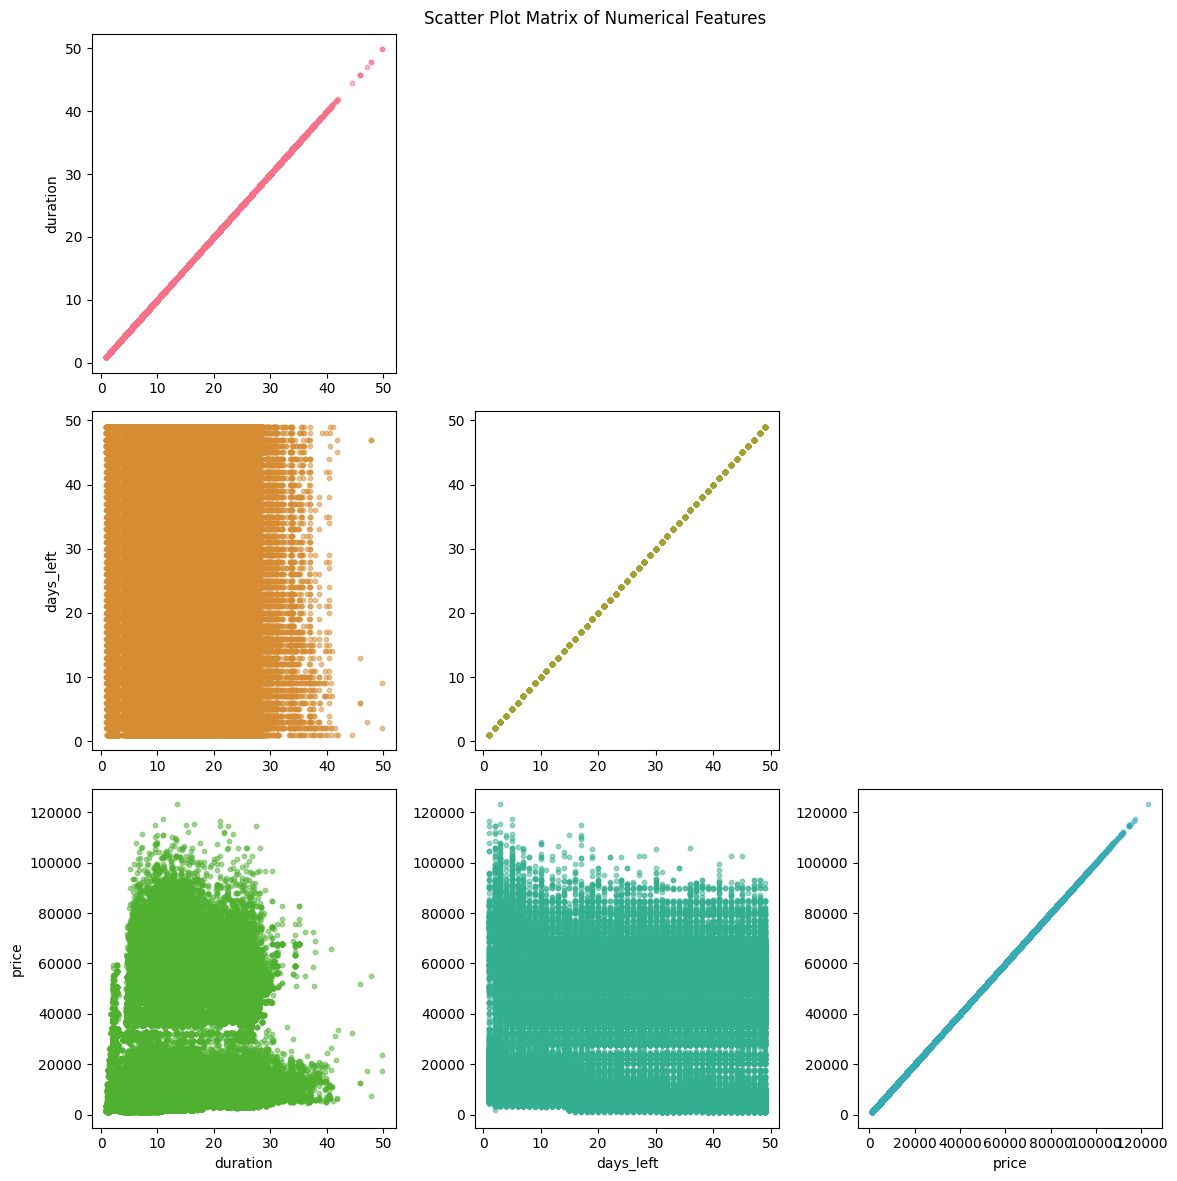

In [85]:
# from pandas.plotting import scatter_matrix
numerical_cols = df_regression.select_dtypes(include='number').columns
plt.figure(figsize=(12, 12))
n = len(numerical_cols)
colors = sns.color_palette("husl", n*n)
cidx = 0
for i in range(n):
    for j in range(i+1):  # Changed this line to create triangle
        plt.subplot(n, n, i*n + j + 1)
        plt.scatter(
            df_regression[numerical_cols[j]], df_regression[numerical_cols[i]], 
            alpha=0.5, c=colors[cidx], s=10
        )
        cidx += 1
        if i == n-1:
            plt.xlabel(numerical_cols[j])
        if j == 0:
            plt.ylabel(numerical_cols[i])
plt.suptitle('Scatter Plot Matrix of Numerical Features')
plt.tight_layout()
# scatter_matrix(df_regression, figsize=(20, 20))
# plt.title('Scatter Matrix of Features')
plt.show()

## Model Implementation & Evaluation

In [86]:
# Dictionary to store models and their results
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0), # Taking Time
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate regression models
modelStorage_regression, prediction_data_regression, results_regression = train_and_evaluate_models(
    regression_models,
    'regressor',
    *create_pipeline(
        df_regression,
        target='price',
        model_type='regressor',  
    ),
    train_percent=20 # Since the dataset is VERY large, we are using only 20% of the data for training to speed up the process. | For 20% it already takes ~6-7.5 minutes.
)

# Convert results to DataFrame for easy viewing
results_df_regression = pd.DataFrame(results_regression).T
results_df_regression['TYPE'] = 'Regression'
print("\nModel Performance Metrics:")
# for name, metrics in results_regression.items():
#     print(f"\n{name}:")
#     for metric, value in metrics.items():
#         print(f"  {metric}: {value:.4f}")
results_df_regression


Model Performance Metrics:


,MAE,MSE,RMSE,Rsqr,TYPE
Linear Regression,4311.622665,3.876099e+07,6225.832201,0.924823,Regression
Ridge Regression,4305.212255,3.872866e+07,6223.235092,0.924885,Regression
Lasso Regression,4369.569043,3.986141e+07,6313.589326,0.922688,Regression
Decision Tree,1233.205186,1.215729e+07,3486.730336,0.976421,Regression
Random Forest,1146.685851,7.599572e+06,2756.732118,0.985261,Regression


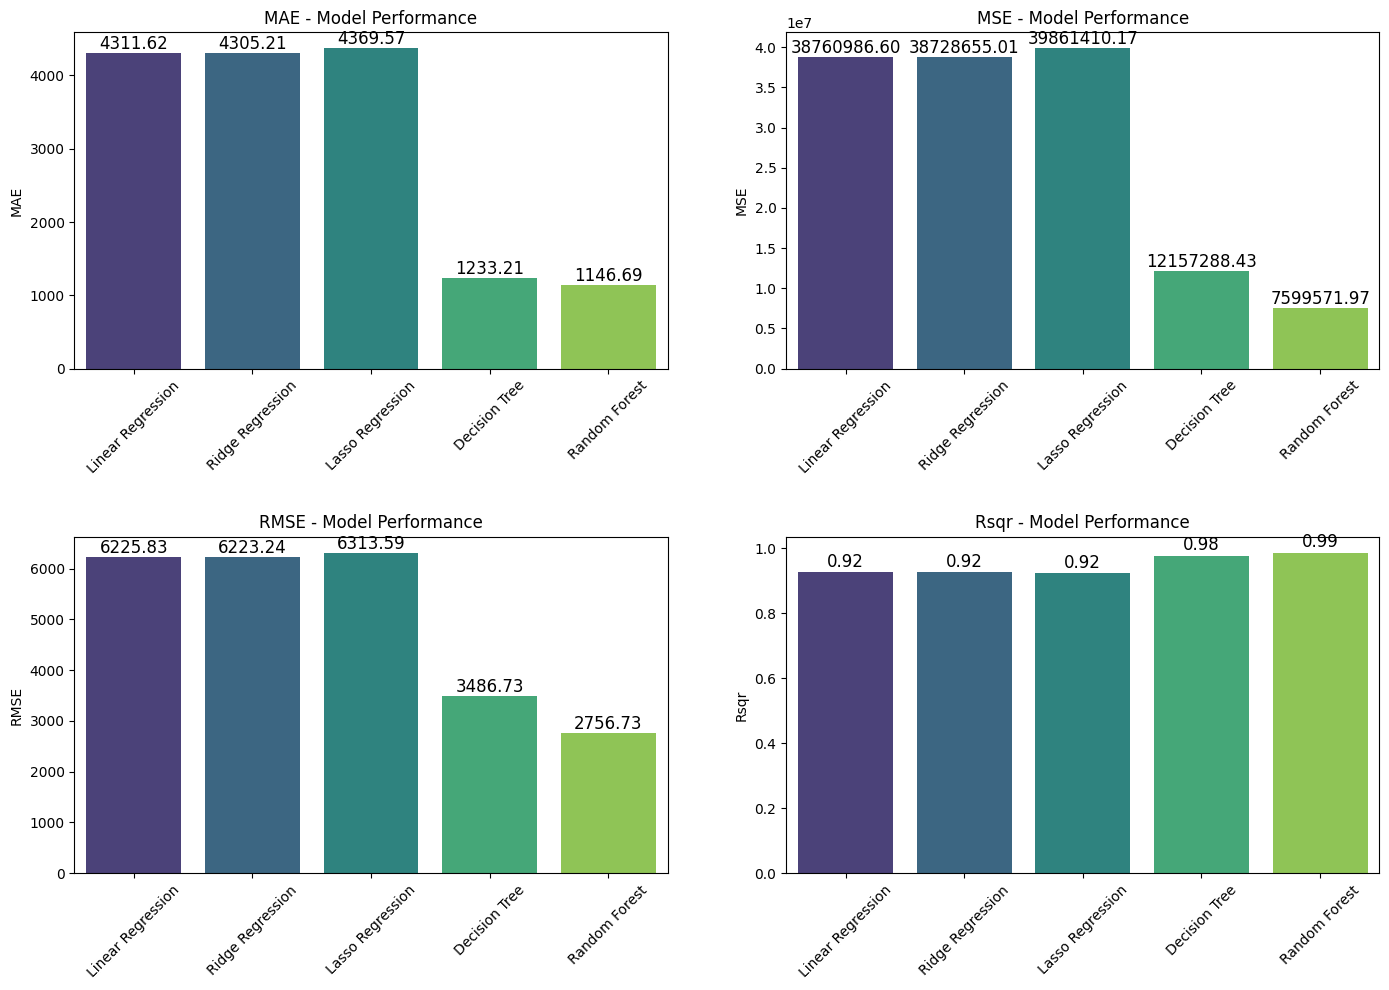

In [87]:
plot_metrics_from_df(results_df_regression)

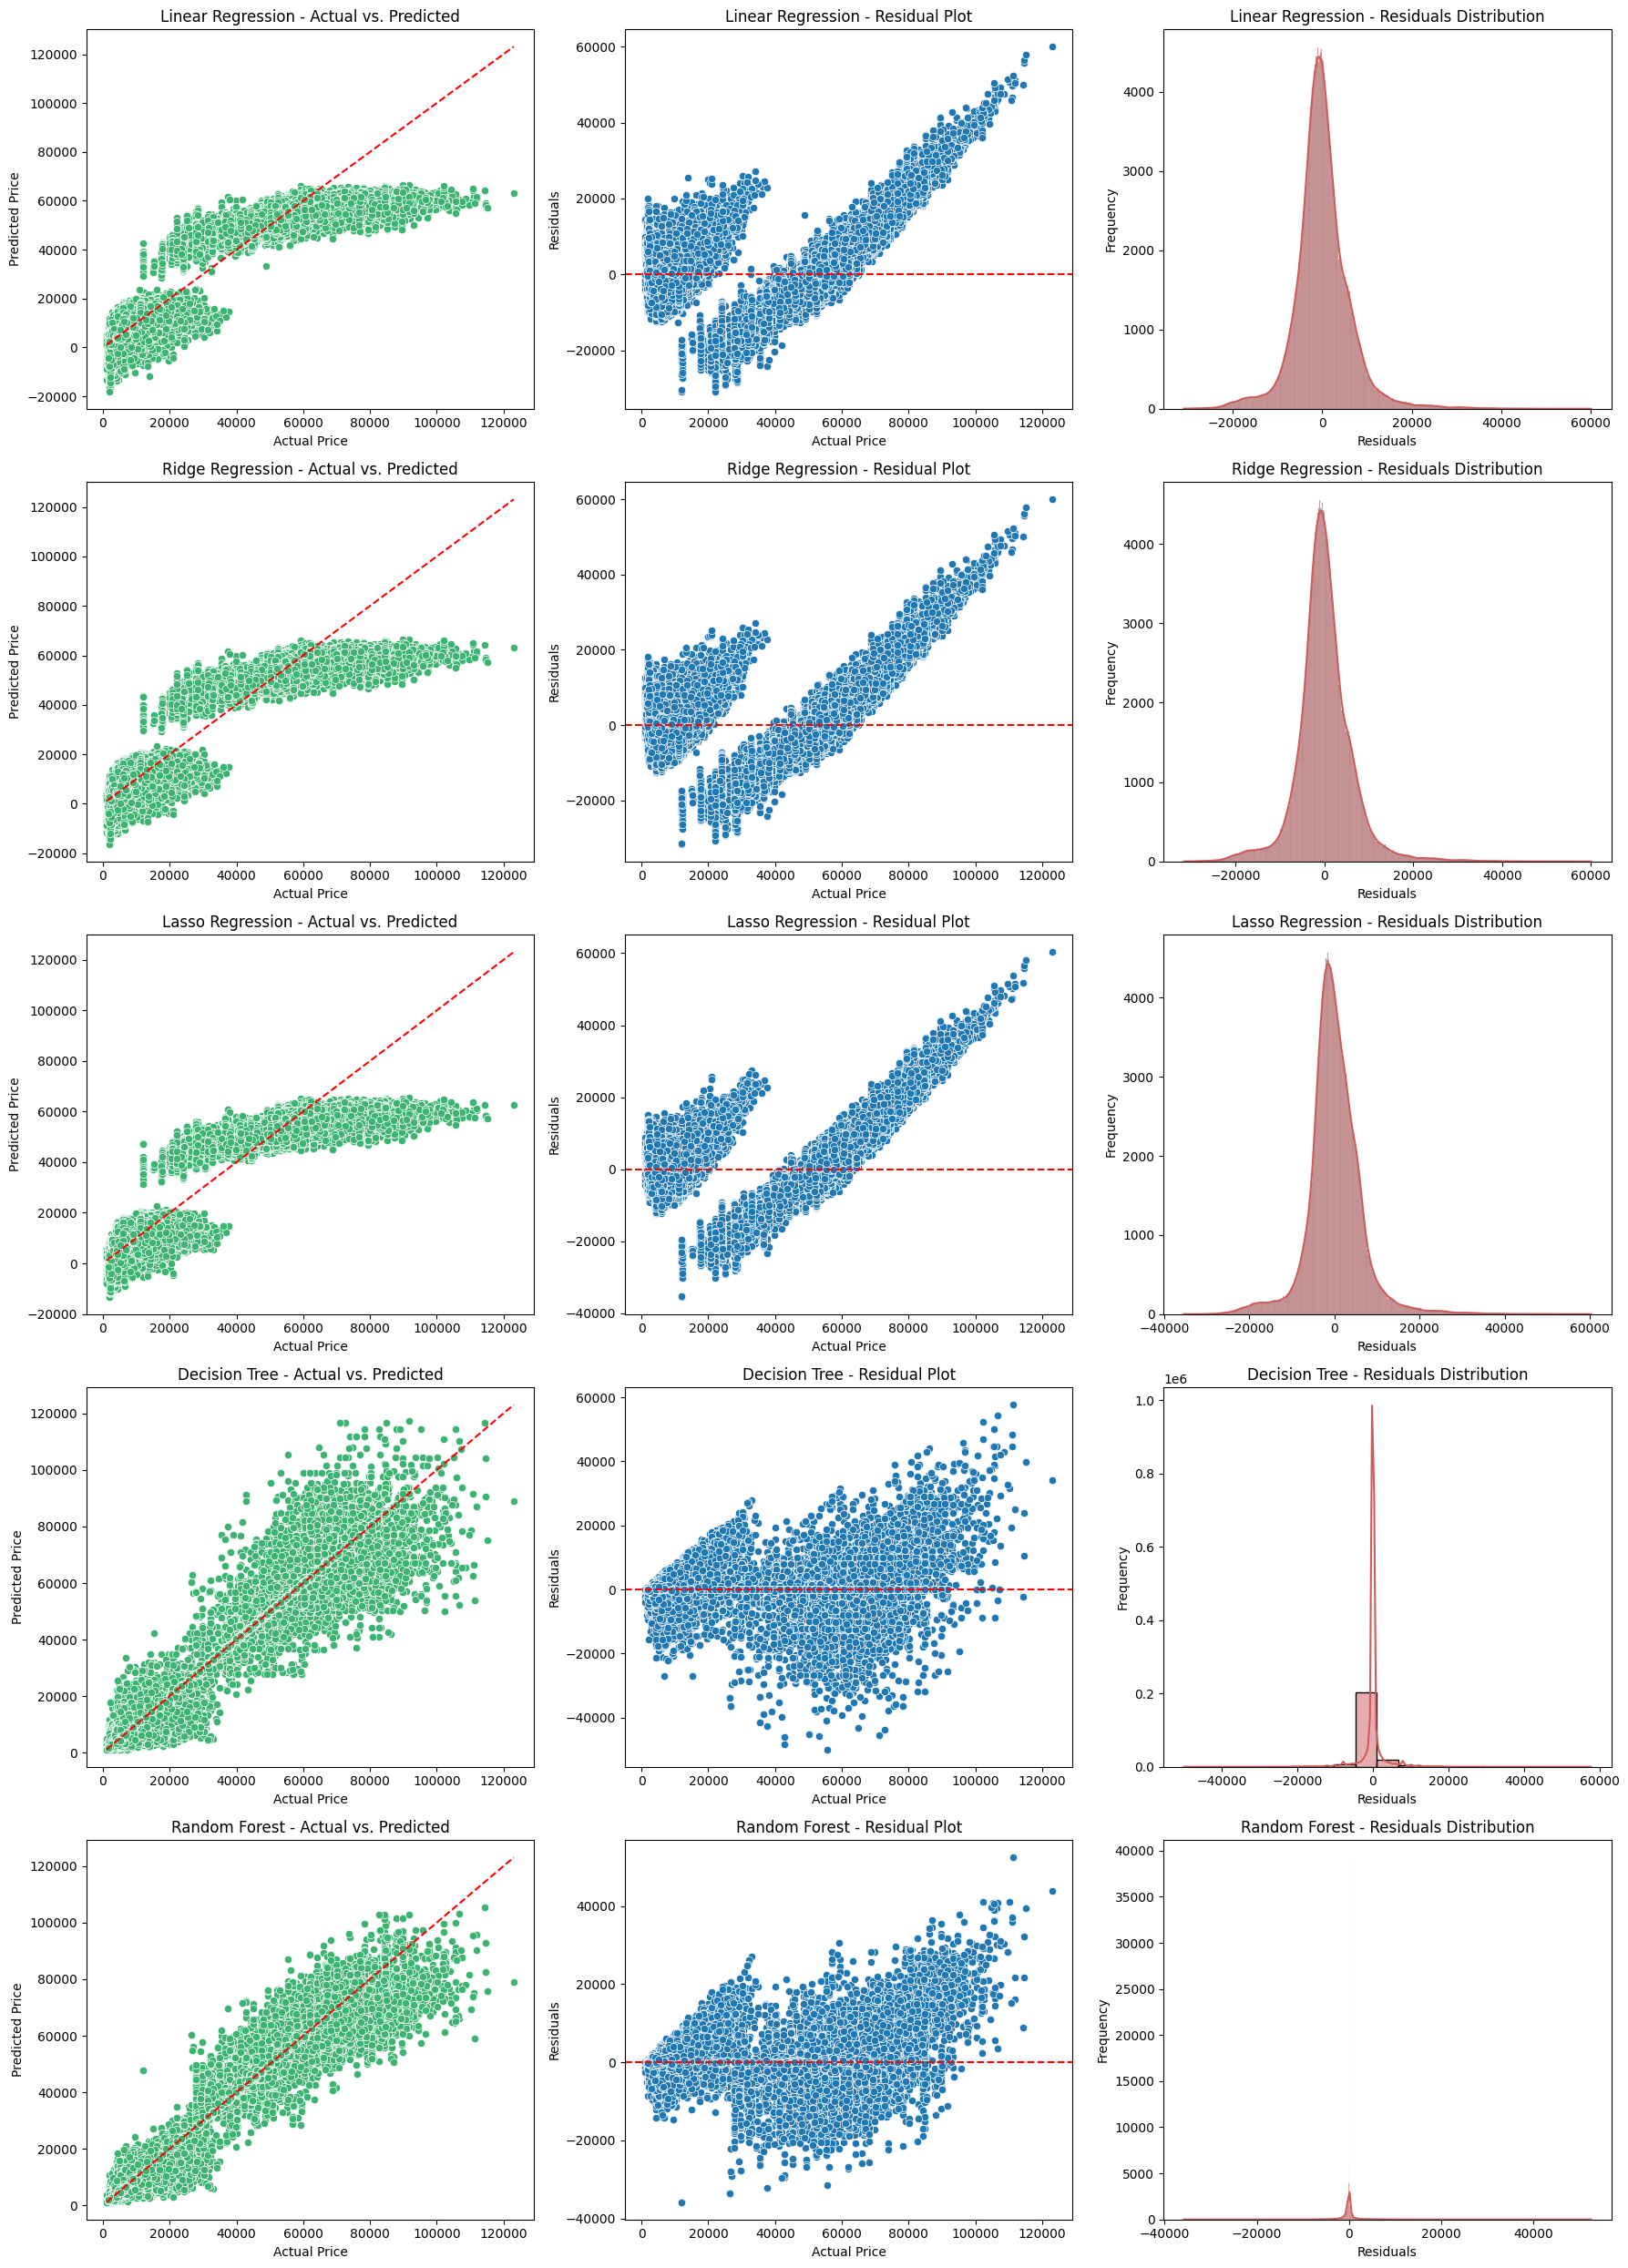

In [102]:
# Determine the number of rows and columns for the subplots
n_cols, n_rows = 3, len(prediction_data_regression)

# Create the figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

# Ensure axes is a 2D array even if there's only one row
if n_rows == 1:
    axes = np.array([axes])

# Loop through the data and plot each graph
for idx, (name, data) in enumerate(prediction_data_regression.items()):
    actual = data['actual']
    predicted = data['predicted']
    residuals = actual - predicted

    # Actual vs. Predicted Plot (Column 1)
    sns.scatterplot(x=actual, y=predicted, ax=axes[idx, 0], color="mediumseagreen")
    axes[idx, 0].plot(
        [actual.min(), actual.max()],
        [actual.min(), actual.max()],
        color="red", linestyle="--"
    )
    axes[idx, 0].set_title(f"{name} - Actual vs. Predicted")
    axes[idx, 0].set_xlabel("Actual Price")
    axes[idx, 0].set_ylabel("Predicted Price")

    # Residual Plot (Column 2)
    sns.scatterplot(x=actual, y=residuals, ax=axes[idx, 1]) # , color="royalblue"
    axes[idx, 1].axhline(0, color="red", linestyle="--")
    axes[idx, 1].set_title(f"{name} - Residual Plot")
    axes[idx, 1].set_xlabel("Actual Price")
    axes[idx, 1].set_ylabel("Residuals")

    # Histogram of Residuals (Column 3)
    sns.histplot(residuals, kde=True, ax=axes[idx, 2], color="indianred")
    axes[idx, 2].set_title(f"{name} - Residuals Distribution")
    axes[idx, 2].set_xlabel("Residuals")
    axes[idx, 2].set_ylabel("Frequency")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Model Interpretation

**Regression Model Evaluation Summaries:**

**Linear Regression:**
This model shows a reasonable ability to predict the target variable, as the predicted values generally follow the trend of the actual values. However, there is some noticeable variability in the predictions, especially at higher actual values. The residuals appear to be roughly centered around zero, but there might be some non-constant variance in the errors. The distribution of the residuals seems approximately normal, but with some skewness.

**Ridge Regression:**
Similar to Linear Regression, Ridge Regression demonstrates a good overall fit to the data, with predicted values generally aligning with the actual values. The variability in predictions seems comparable to Linear Regression. The residuals are also distributed around zero, potentially with some non-constant variance. The residual distribution appears approximately normal.

**Lasso Regression:**
Lasso Regression also shows a good fit to the data, with predicted values generally following the actual values. The spread of predicted values around the actual values seems similar to Linear and Ridge Regression. The residuals are centered around zero, with a possible trend of non-constant variance. The distribution of residuals appears roughly normal.

**Decision Tree:**
This model appears to perform significantly better than the linear models. The predicted values closely match the actual values across the entire range, indicating a strong fit. The residuals are tightly clustered around zero, suggesting small prediction errors and relatively constant variance. The distribution of the residuals is heavily concentrated around zero.

**Random Forest:**
The Random Forest model shows the best performance among the evaluated models. The predicted values almost perfectly align with the actual values, indicating an excellent fit. The residuals are very tightly distributed around zero, suggesting very small and consistent prediction errors. The distribution of the residuals is highly concentrated around zero.

In [89]:
best_model_regression = get_best_model(results_df_regression, 'regressor')
# best_model_regression = results_df_regression['Rsqr'].idxmax() # results_df_regression['MSE'].idxmin()
print(f"\nBest Model: {best_model_regression}")
# best_model_regression_pipeline = modelStorage_regression[best_model_regression]
modelStorage_regression[best_model_regression]


Best Model: Random Forest


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['airline', 'flight',
                                                   'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city',
                                                   'class'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

--------------------------------------------------

# Classification Task
**Dataset**: Phishing Websites dataset

**Source**: [UCI ML Repository](https://archive.ics.uci.edu/dataset/327/phishing+websites)

**Objective**: To classify websites as either legitimate or phishing based on various URL and website features. This classification model will help improve cybersecurity by automatically identifying potentially malicious websites that attempt to steal sensitive information from users.

## Classification Dataset

In [90]:
try:
    # fetch dataset 
    phishing_websites = fetch_ucirepo(id=327) 
except Exception as e:
    print(f"Error loading dataset: {e}")
    phishing_websites = fetch_ucirepo(name='Phishing Websites') # fetch dataset by name
finally:
    X =  pd.DataFrame(phishing_websites.data.features) # Features | phishing_websites.data.features
    y =  pd.DataFrame(phishing_websites.data.targets) # Target variable | phishing_websites.data.targets
    df_classification = pd.concat([X, y], axis=1) # concatenate features and target variable
df_classification

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11050,1,-1,1,-1,1,1,1,1,-1,-1,...,-1,-1,1,1,-1,-1,1,1,1,1
11051,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,1,1,1,1,1,1,-1,1,-1
11052,1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,-1
11053,-1,-1,1,1,1,-1,-1,-1,1,-1,...,-1,1,1,1,1,-1,1,1,1,-1


## Understanding the Data

In [91]:
df_classification.describe(include='all')

,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,0.628584,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,0.777777,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [92]:
df_classification.shape

(11055, 31)

In [93]:
df_classification.info() # df_classification.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   having_ip_address           11055 non-null  int64
 1   url_length                  11055 non-null  int64
 2   shortining_service          11055 non-null  int64
 3   having_at_symbol            11055 non-null  int64
 4   double_slash_redirecting    11055 non-null  int64
 5   prefix_suffix               11055 non-null  int64
 6   having_sub_domain           11055 non-null  int64
 7   sslfinal_state              11055 non-null  int64
 8   domain_registration_length  11055 non-null  int64
 9   favicon                     11055 non-null  int64
 10  port                        11055 non-null  int64
 11  https_token                 11055 non-null  int64
 12  request_url                 11055 non-null  int64
 13  url_of_anchor               11055 non-null  int64
 14  links_

In [94]:
# Tells us if there are any missing values in the dataset
print("Missing values in the dataset:")
int(df_classification.isnull().sum().sum()) # There aren't any missing values in the dataset

Missing values in the dataset:


0

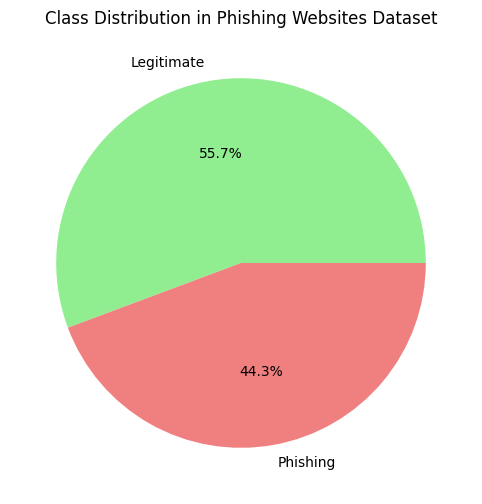

In [95]:
# Examine class distribution of the target variable
class_dist = df_classification['result'].value_counts()
# Calculate percentages
total = len(df_classification)
percentages = (class_dist / total * 100).round(1)
# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(class_dist, labels=['Legitimate', 'Phishing'], 
    autopct=lambda pct: f'{pct:.1f}%',
    colors=['lightgreen', 'lightcoral'])
plt.title('Class Distribution in Phishing Websites Dataset')
plt.show()

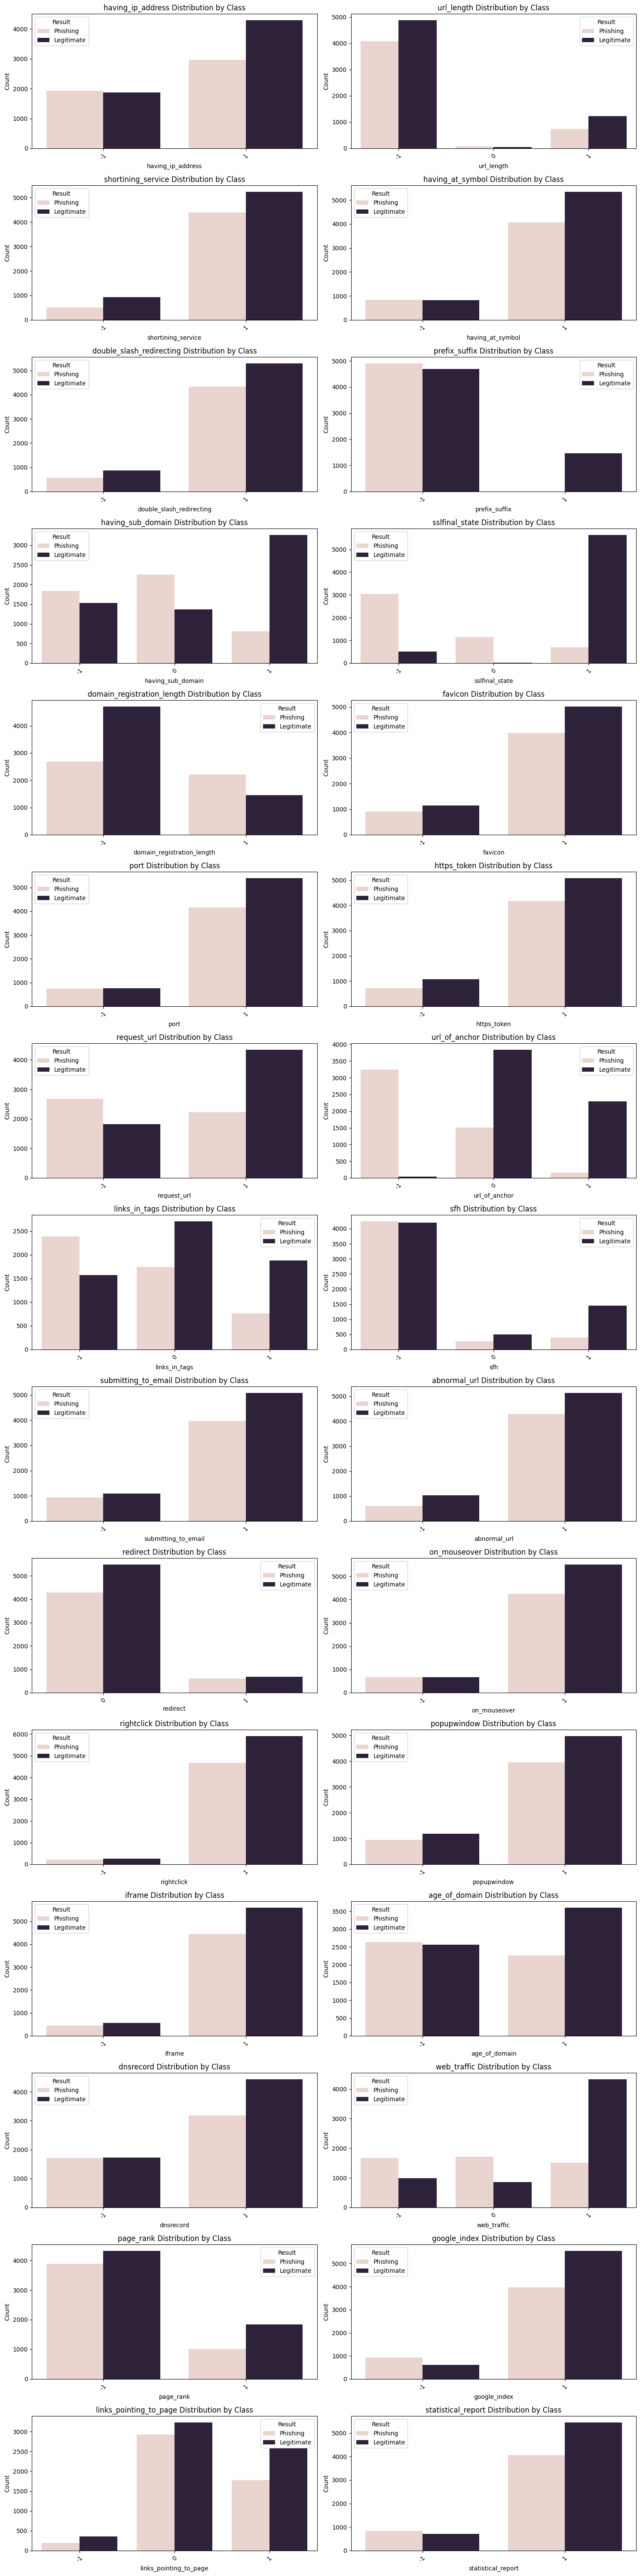

In [96]:
features_to_plot = [ftp for ftp in df_classification.columns if ftp != 'result'] # [ftp[0] for ftp in df_classification.corr().loc['result'].abs().sort_values(ascending=False).items() if ftp[0] != 'result']
n_cols = 2 if len(features_to_plot) % 2 == 0 else 3
n_rows = (len(features_to_plot) + 1) // n_cols
plt.figure(figsize=(15, 4*n_rows))
for idx, feature in enumerate(features_to_plot, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.countplot(data=df_classification, x=feature, hue='result')
    plt.title(f'{feature} Distribution by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Result', labels=['Phishing', 'Legitimate'])
plt.tight_layout()
plt.show()
# # Display value counts for categorical variables
# for col in df_classification.select_dtypes(include='object').columns:
#     print(f"Column: {col}")
#     print(df_classification[col].value_counts())
#     print("\n")

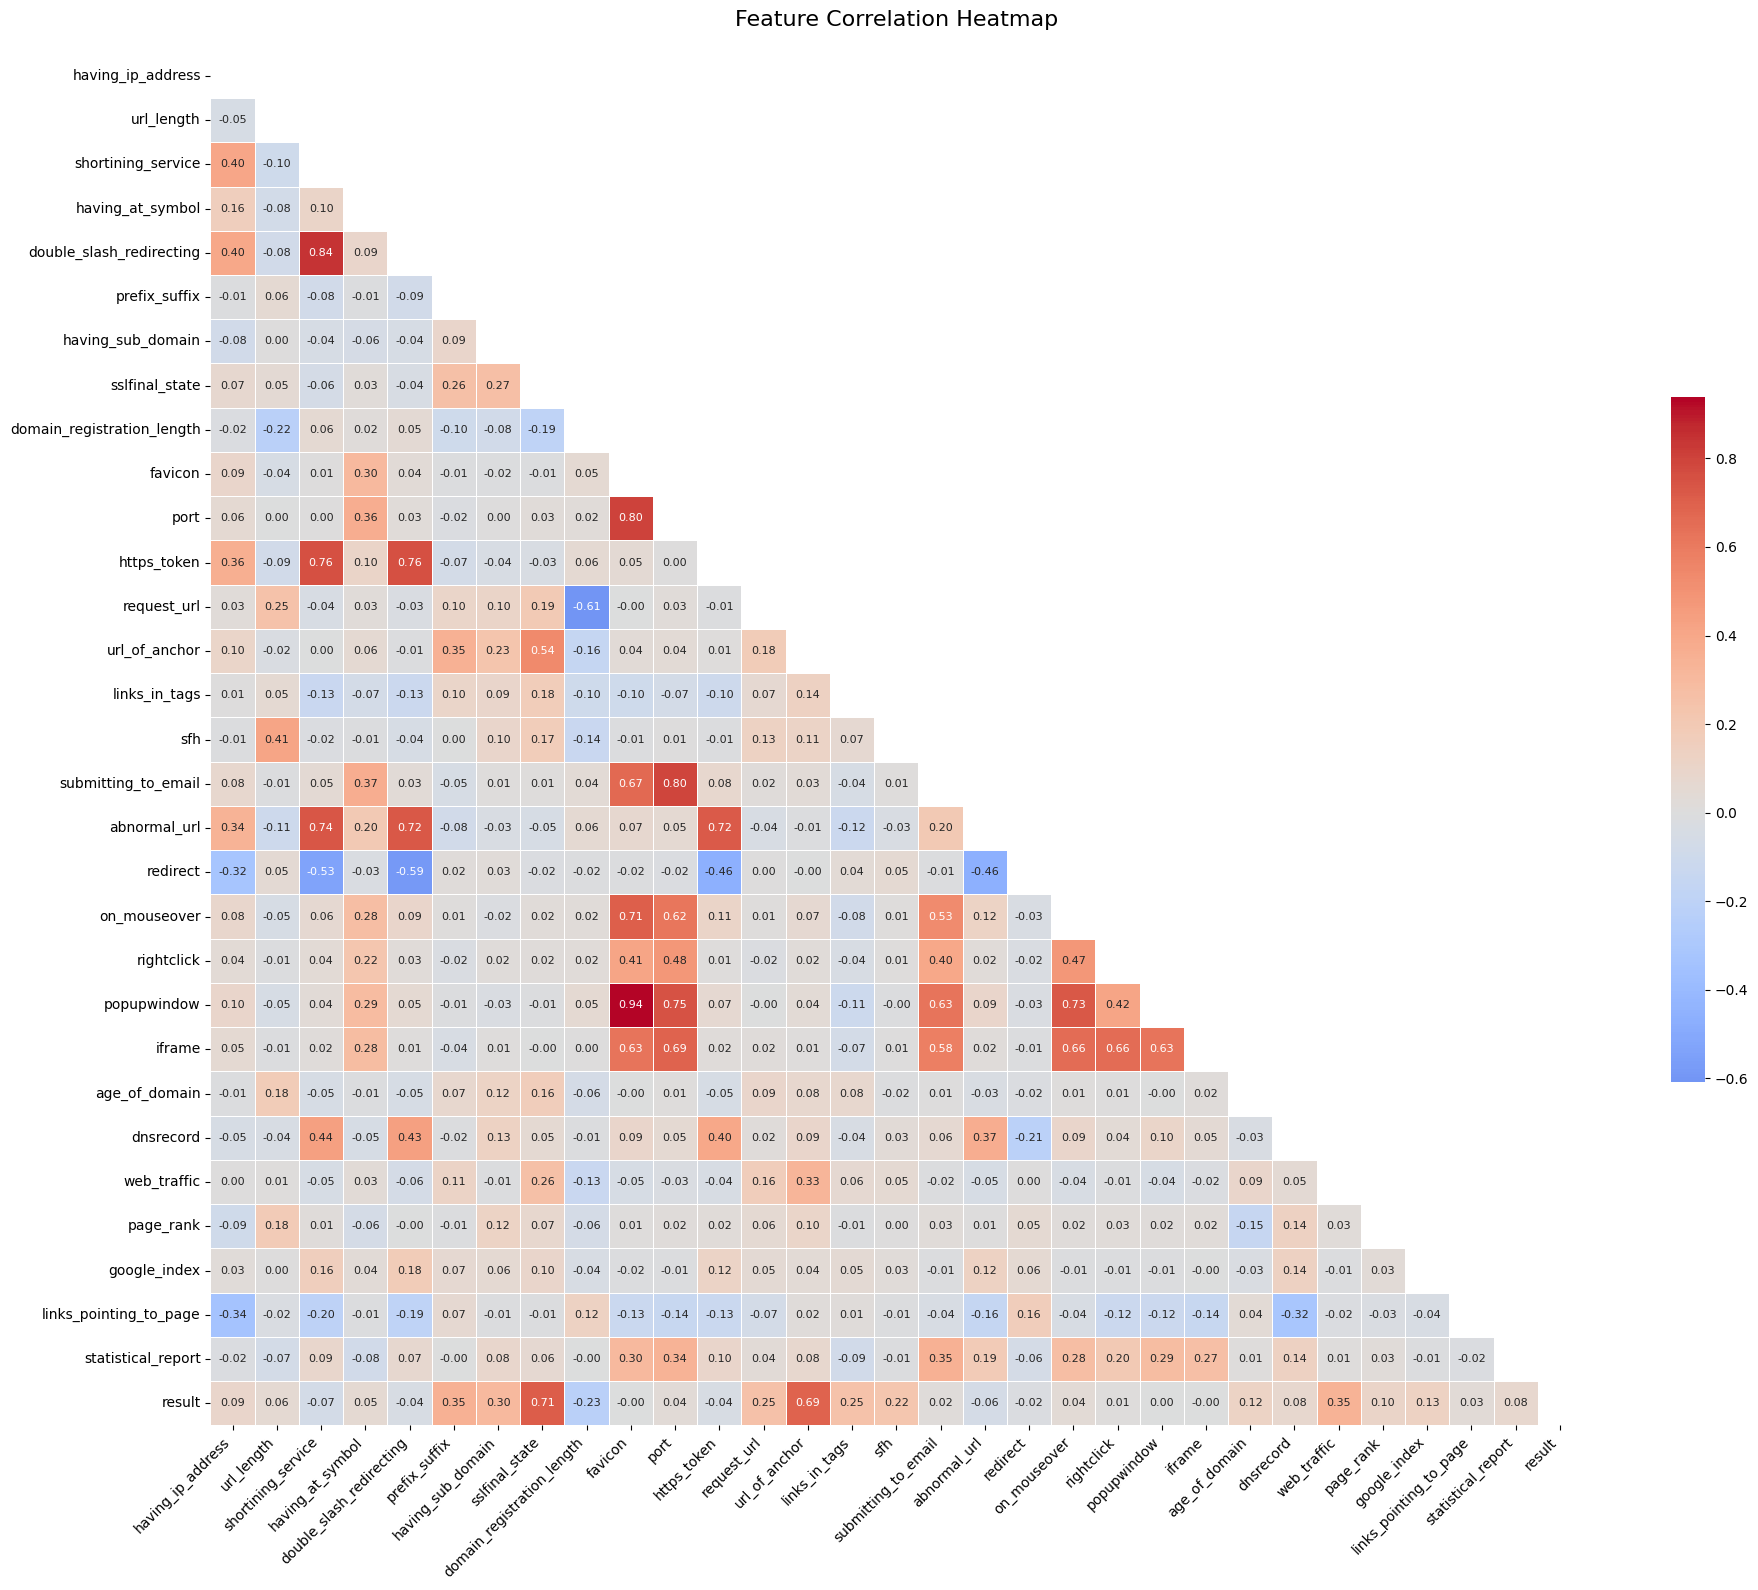

In [97]:
# Compute correlation matrix
correlation_matrix = df_classification.corr()
# Create mask for upper triangle to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix))
# Set up the matplotlib figure
plt.figure(figsize=(20, 16))
# Create heatmap with better visualization
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,  # Show correlation values
            fmt='.2f',   # Round to 2 decimal places
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .5},
            annot_kws={"size": 8})
plt.title('Feature Correlation Heatmap', pad=20, size=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Model Implementation & Evaluation

In [98]:
# Dictionary to store models and their results
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

# Train and evaluate classification models
modelStorage_classification, prediction_data_classification, results_classification = train_and_evaluate_models(
    classification_models,
    'classifier',
    *create_pipeline(
        df_classification,
        target='result',
        model_type='classifier',  
    ),
    train_percent=80
)

# Convert results to DataFrame for easy viewing
results_df_classification = pd.DataFrame(results_classification).T
results_df_classification['TYPE'] = 'classification'
print("\nModel Performance Metrics:")
# for name, metrics in results_classification.items():
#     print(f"\n{name}:")
#     for metric, value in metrics.items():
#         print(f"  {metric}: {value:.4f}")
results_df_classification


Model Performance Metrics:


,Accuracy,Precision,Recall,F1-Score,TYPE
Logistic Regression,0.924469,0.924407,0.924469,0.924394,classification
Support Vector Machine,0.952510,0.952728,0.952510,0.952401,classification
Decision Tree,0.957485,0.957485,0.957485,0.957485,classification
Random Forest,0.966983,0.967069,0.966983,0.966937,classification
K-Nearest Neighbors,0.942560,0.942591,0.942560,0.942471,classification


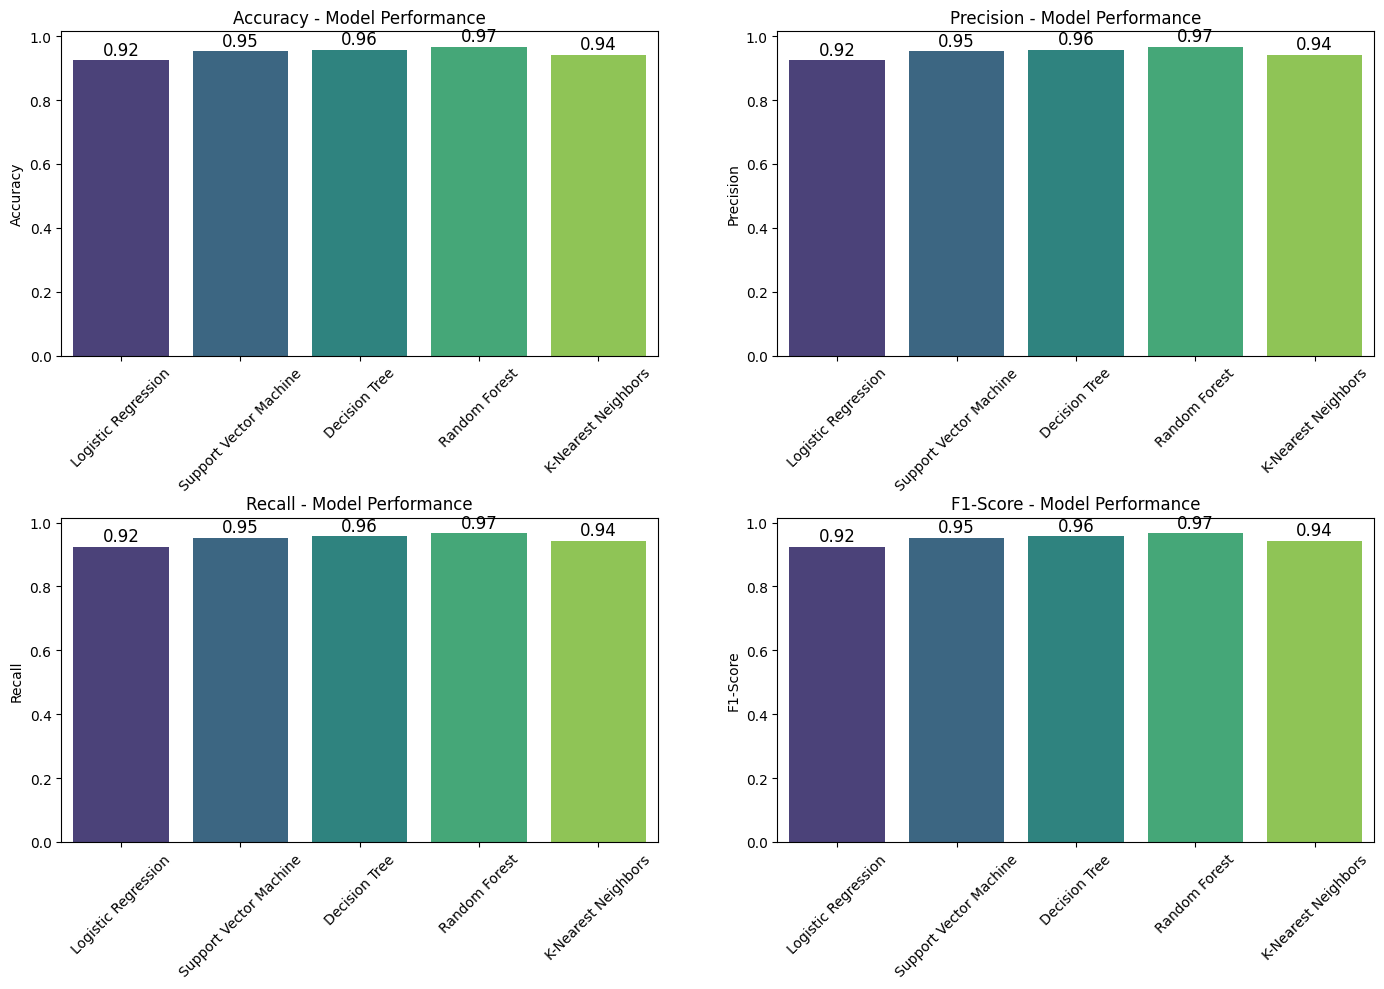

In [99]:
plot_metrics_from_df(results_df_classification)

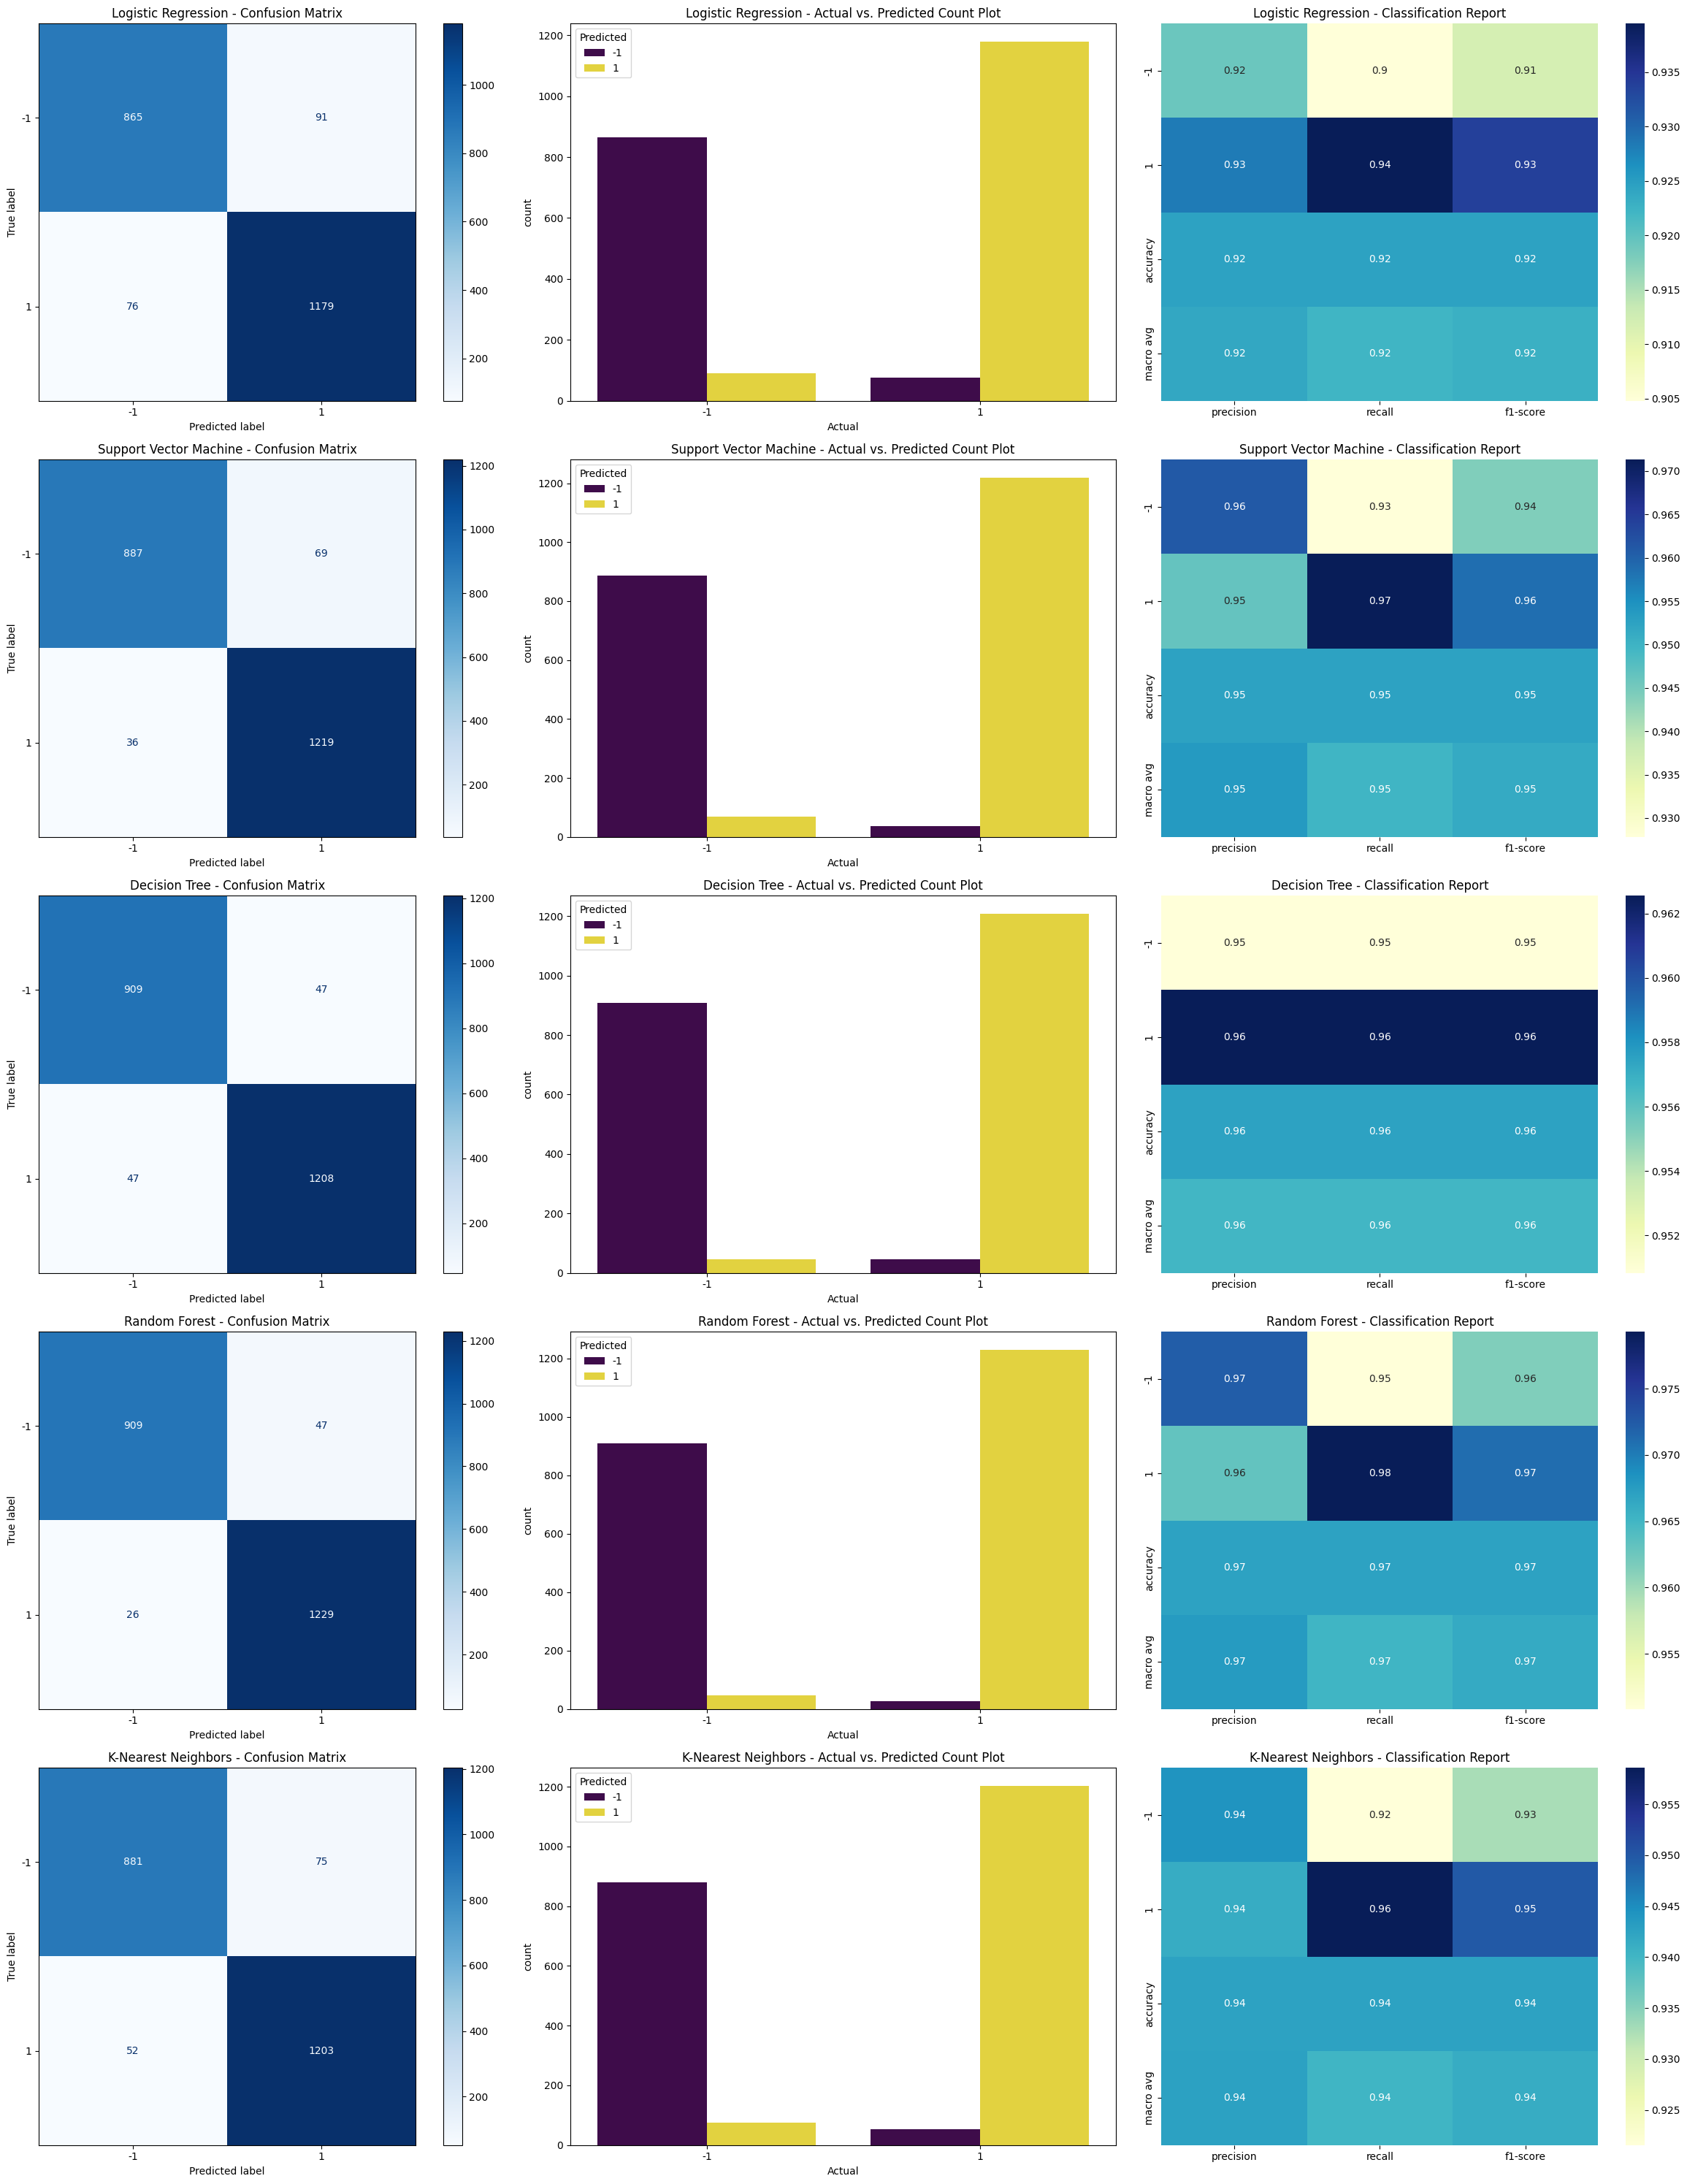

In [100]:
columnCount = 3
fig, axs = plt.subplots(len(prediction_data_classification), columnCount, figsize=(8*columnCount, 6 * len(prediction_data_classification)))
for i, (name, data) in enumerate(prediction_data_classification.items()):
    df = pd.DataFrame({'Actual': data['actual'], 'Predicted': data['predicted']})
    # """
    # Confusion Matrix
    cm = confusion_matrix(data['actual'], data['predicted'], labels=sorted(data['actual'].value_counts().index))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(data['actual'].value_counts().index))
    disp.plot(cmap='Blues', ax=axs[i, 0])
    axs[i, 0].set_title(f"{name} - Confusion Matrix")
    # Count Plot
    sns.countplot(x='Actual', hue='Predicted', data=df, palette='viridis', ax=axs[i, 1])
    """
    # Heatmap
    heatmap_data = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', ax=axs[i, 0])
    axs[i, 0].set_title(f"{name} - Actual vs. Predicted Heatmap")
    # Bar Plot
    grouped_data = df.groupby(['Actual', 'Predicted']).size().reset_index(name='Count')
    sns.barplot(x='Actual', y='Count', hue='Predicted', data=grouped_data, palette='muted', ax=axs[i, 1])
    # """
    axs[i, 1].set_title(f"{name} - Actual vs. Predicted Count Plot")
    # Classification Report Heatmap
    report = classification_report(data['actual'], data['predicted'], output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='YlGnBu', ax=axs[i, 2]) # Exclude support and macro/weighted avg
    axs[i, 2].set_title(f"{name} - Classification Report")
plt.tight_layout()
plt.show()

## Model Interpretation

**Model Evaluation Summaries:**

**Logistic Regression:**
This model appears to have performed well in classifying both categories, showing a high number of correct predictions for both. The predicted counts for each category closely align with the actual counts. The classification report indicates strong performance across precision, recall, and F1-score for both classes.

**Support Vector Machine:**
This model also demonstrates good classification performance, with a high number of accurate predictions for both categories. The predicted counts are consistent with the actual counts. The classification report suggests a high level of precision, recall, and F1-score for both classes.

**Decision Tree:**
The decision tree model shows a good ability to classify instances in both categories, with a significant number of correct predictions. The predicted counts for each category are close to the actual counts. The classification report indicates a strong performance with high precision, recall, and F1-score for both classes.

**Random Forest:**
This model exhibits excellent classification performance, with a very high number of correct predictions for both categories. The predicted counts almost perfectly match the actual counts. The classification report shows very high precision, recall, and F1-score for both classes, suggesting it's a strong performing model.

**K-Nearest Neighbors:**
This model demonstrates good classification capabilities, achieving a good number of correct predictions for both categories. The predicted counts are reasonably close to the actual counts. The classification report indicates high precision, recall, and F1-score for both classes, although perhaps slightly lower than the Random Forest model.

In [101]:
best_model_classification = get_best_model(results_df_classification, 'classifier')
# best_model_classification = results_df_classification['Accuracy'].idxmax() # ALTERANTIVE: Select the best model based on a single metric
print(f"\nBest Model: {best_model_classification}")
# best_model_classification_pipeline = modelStorage_classification[best_model_classification]
modelStorage_classification[best_model_classification]


Best Model: Random Forest


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['having_ip_address',
                                                   'url_length',
                                                   'shortining_service',
                                                   'having_at_symbol',
                                                   'double_slash_redirecting',
                                                   'prefix_suffix',
                                                   'having_sub_domain',
                                                   'sslfinal_state',
                                                   'domain_registration_length',
                                                   'favi...
                                                   'on_mouseover', 'rightclick',
                                                   'popupwindow', 'iframe',
                                                   'age_of_domain', 'dnsrecord',
                                                   'web_traffic', 'page_rank',
                                                   'google_index',
                                                   'links_pointing_to_page',
                                                   'statistical_report']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier', KNeighborsClassifier())])

--------------------------------------------------

# Summary:

## Conclusion

### Summary of Findings

This project demonstrated the application of machine learning for two distinct tasks:

1. **Regression Task (Flight Price Prediction)**:
   - Random Forest Regressor provided the best performance, capturing the complex non-linear relationships in flight pricing data
   - Linear models showed limitations in predicting the extreme prices, particularly for high-cost flights
   - The analysis suggests that ensemble methods are particularly well-suited for price prediction tasks with multiple categorical and numerical features

2. **Classification Task (Phishing Website Detection)**:
   - All models performed well, with Random Forest achieving the highest overall metrics
   - The high classification accuracy across models indicates that the features extracted from websites provide strong signals for phishing detection
   - The balanced performance between precision and recall makes these models practical for real-world implementation in security systems

### Challenges and Limitations

Several challenges were encountered during this project:

1. **Regression Task**:
   - The right-skewed distribution of flight prices created challenges for prediction models
   - Complex interactions between categorical variables like airlines and destinations required sophisticated preprocessing
   - Training time for models (particularly Lasso) was significant due to the large dataset size

2. **Classification Task**:
   - Interpreting the importance of various website features requires domain expertise
   - The binary nature of the problem simplifies classification but real-world phishing detection often involves more nuanced categories

### Real-world Implications

The models developed in this project have significant real-world applications:

1. **Flight Price Prediction**:
   - Airlines could use similar models for dynamic pricing strategies
   - Travel agencies and comparison websites could implement these models to provide price forecasts to customers
   - Consumers could use predictions to optimize their travel planning and booking timing

2. **Phishing Website Detection**:
   - Browser extensions could implement these models to provide real-time warnings about potentially malicious websites
   - Email filtering systems could scan links for phishing indicators before delivery
   - Security training platforms could use model insights to better educate users about the characteristics of phishing attempts

### Future Work

Potential directions for future work include:

1. **Flight Price Prediction**:
   - Incorporating temporal features like seasonality and holiday periods
   - Adding external data sources such as fuel prices and competitor pricing
   - Developing specialized models for specific routes or airlines

2. **Phishing Website Detection**:
   - Exploring deep learning approaches for feature extraction from raw HTML
   - Developing models that can explain their classification decisions to users
   - Implementing continuous learning systems that adapt to evolving phishing techniques

## References

1. [Scikit-learn Column Transformer Documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)
2. [UCI Machine Learning Repository: Phishing Websites Dataset](https://archive.ics.uci.edu/dataset/327/phishing+websites)
3. [Kaggle: Flight Price Prediction Dataset](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction)
4. [Scikit-learn Documentation: Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)
5. [Scikit-learn Documentation: Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
6. [Random Forest Algorithm: Theory and Applications](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

# THE END!